In [11]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sklearn
from scipy import ndimage, misc
import math
%matplotlib inline
import cv2
import time
import glob


In [14]:
def FindContour_and_outer_defect(gray, contours_final,debug):
    
    hull = cv2.convexHull(contours_final[0])
    #=====
    convex_img = np.ones_like(gray)
    cv2.drawContours(convex_img, [hull],-1,(0,0,0),-1)
    convex_img = np.invert(convex_img)
    #=====
    contour_img = np.ones_like(gray)
    cv2.drawContours(contour_img, [contours_final[0]],-1,(0,0,0),-1)
    #print(contours_final[0].shape)
    mask = 1-contour_img
    contour_img = np.invert(contour_img)
    #=====
    diff_img = convex_img - contour_img
    #=====
    #kernel = np.ones((3,3),np.uint8)
    kernel = np.ones((3,2),np.uint8)
    opening = cv2.morphologyEx(diff_img, cv2.MORPH_OPEN, kernel)
    #=====
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(opening)
    
    if(debug):
        plt.figure(figsize=(20,20))
        plt.imshow(contour_img,cmap = 'gray')    
    
    return stats, mask

def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center < (radius+15)
    return mask

def mask_innercicle(img,debug):
    
    ret, thresh1 = cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)
    _ , contours, hierarchy = cv2.findContours(thresh1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    
    #backtorgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)   
    import circle_fit as cf
    contours_final = []
    for i in range(np.array(contours).shape[0]):
            
            if(cv2.contourArea(contours[i])>1000000 and cv2.contourArea(contours[i])<2500000):
                #print(cv2.contourArea(contours[i]))
                contours_final.append(contours[i])
                #cv2.drawContours(backtorgb, contours, i, (255, 0, 0), 4);
                
    #if(debug):
#        plt.figure(figsize=(20,20))
#        plt.imshow(backtorgb,cmap = 'gray')        
    
    #===================circle fit for inner cycle=============================
    cor = np.array(contours_final[1])
    cor = cor.reshape(cor.shape[0],cor.shape[2])

    xc,yc,r,_ = cf.least_squares_circle(cor)

    h = img.shape[0]
    w = img.shape[1]
    center = (xc.astype(int), yc.astype(int))
    radius = r.astype(int)
    mask = create_circular_mask(h, w, center=center, radius=radius)
    
    mask_array = np.ma.masked_array(img, mask=mask,fill_value = 255)
    #plt.figure(figsize=(20,20))
    #plt.imshow(mask,cmap = 'gray')       
    
    img_temp = mask_array.filled()
    
    return img_temp, contours_final

0518ALL_Data/CCD-2\1.jpg
3.310633659362793
.\Detect\Stop2\1_Detect.jpg
0518ALL_Data/CCD-2\10.jpg
2.7992019653320312
.\Detect\Stop2\10_Detect.jpg


KeyboardInterrupt: 

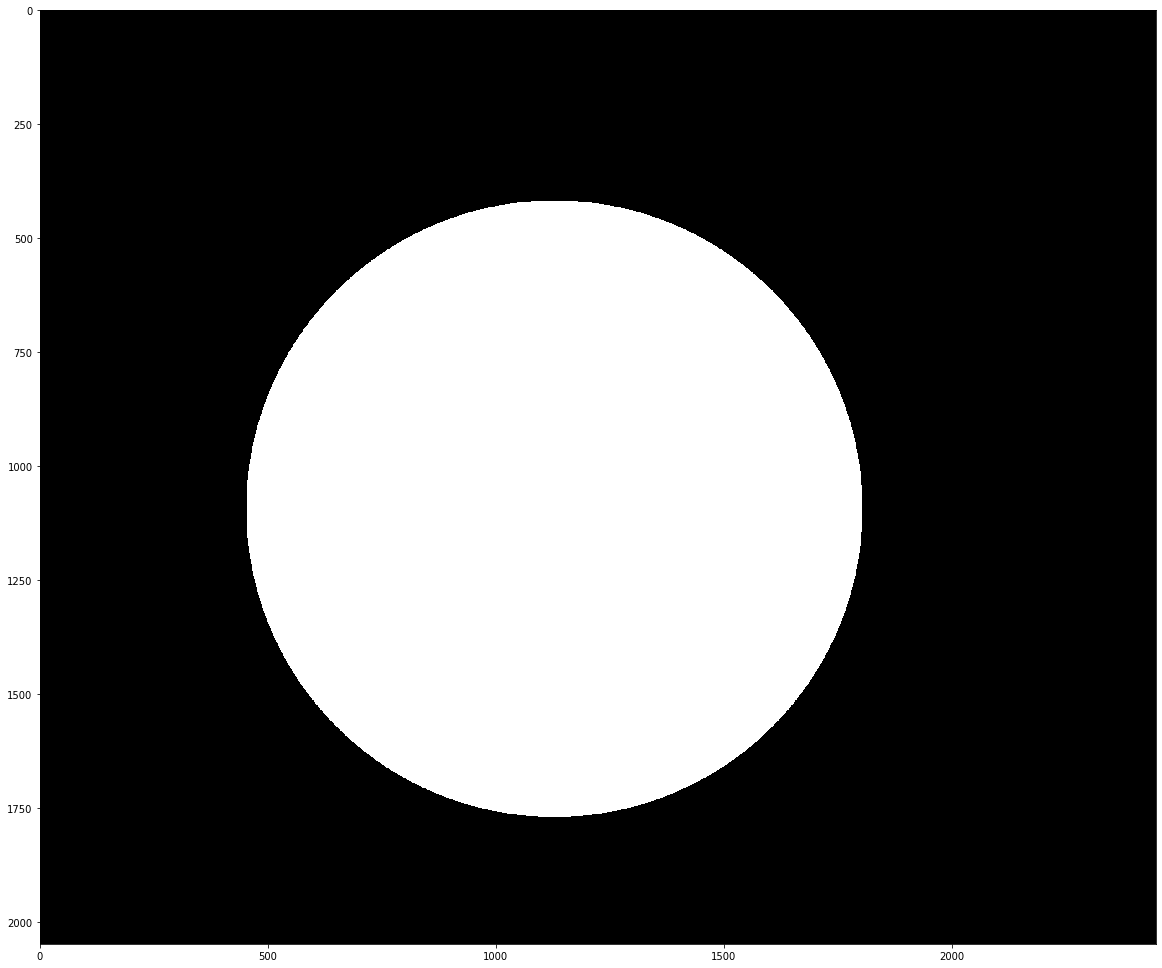

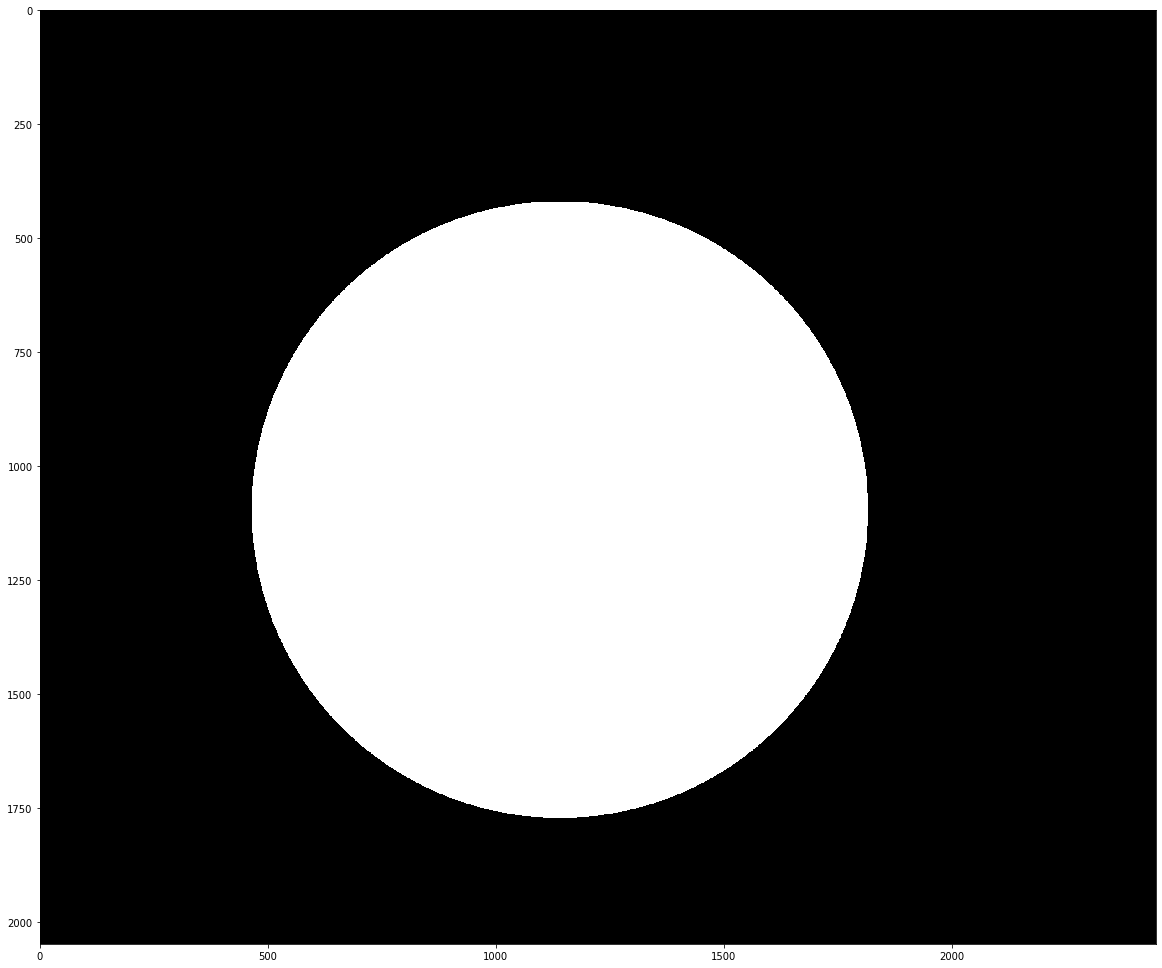

In [16]:
debug = 0
img_list = []
filenamelist= []
for img in glob.glob("0518ALL_Data/CCD-2/*.jpg"):
    #img_list.append(cv2.imread(img,0))
    filenamelist.append(img)

if(debug):
    filenamelist = ["0518ALL_Data/CCD-2/12.jpg"]

for iter_file in range(len(filenamelist)):
    start = time.time()
    filename = filenamelist[iter_file]
    #filename = filenamelist[0]
    print(filename)
    original_image = np.array(cv2.imread(filename,0))
    #image = original_image.copy()
    
    backtorgb = cv2.cvtColor(original_image,cv2.COLOR_GRAY2RGB)   
    mask_inner_cycle_image,contours_final = mask_innercicle(original_image,debug)
    
    #=====Find Defect outer
    stats, mask = FindContour_and_outer_defect(original_image,contours_final,debug)
    #mask outer glass noise
    #print(mask[mask=0])
    original_image = mask_inner_cycle_image
    #image[mask==0] = 255
    #===================Draw outer defect=============================    
    for j in range(len(stats)):
        area = stats[j][4]
        if(area < 20000):
            cv2.rectangle(backtorgb, (stats[j][0], stats[j][1]), 
                          (stats[j][0]+stats[j][2], stats[j][1]+stats[j][3]), (0, 255,0),3)
    #=================================================================
    #=================================用canny找出輪廓==================
    '''
    #image = cv2.blur(image,(3,3))
    #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    #image = cv2.filter2D(image, -1, kernel)
    
    #if(debug):
    #    plt.figure(figsize=(20,20))
    #    plt.imshow(image,cmap = 'gray')
    
    image = cv2.GaussianBlur(image,(17,17),0,0)
    image = cv2.Canny(image,0,45,3)
    
    if(debug):
        plt.figure(figsize=(20,20))
        plt.imshow(image,cmap = 'gray')
    #===============================closing===============================
    #close_kernel = np.ones((11,11),np.uint8)
    close_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(33,33))
    close_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, close_kernel)
    image = close_image - image
    if(debug):
        plt.figure(figsize=(20,20))
        plt.imshow(close_image,cmap = 'gray')
    #==================用findcontours把canny得到的 ROI切出來===============

    _ , contours, hierarchy = cv2.findContours(image,cv2.RETR_TREE,cv2.RETR_CCOMP )
    hierarchy = hierarchy[0]
    inner_contours_final = []
    approx_list = []
    index = []
    for i in range(np.array(contours).shape[0]):
        #if (hierarchy[0][i][3] >= 0):
            if(cv2.contourArea(contours[i])<10000 and cv2.contourArea(contours[i])>150):
                #cv2.drawContours(backtorgb, contours, i, (0, 255, 0), 1, 8);
                #inner_contours_final.append(contours[i])
                epsilon = 0.0005# * cv2.arcLength(contours[i],True)
                index.append(i)
                approx = cv2.approxPolyDP(contours[i], epsilon, False)
                #print(cv2.contourArea(approx))
                approx_list.append(approx)
                #print(np.array(approx_list).shape)
                
                #濾掉白的部分
                
                mask = np.zeros_like(image)
                mask_now = cv2.fillPoly(mask, [approx],1)
                mask_1 = original_image*mask_now
                
                min_in_poly = np.min(mask_1[mask_1>0])
                mean_in_poly = np.mean(mask_1[(mask_1>0)])
                
                mean_in_poly2 = [255 for n in range(4)]
                M = [np.float32([[1, 0, 15], [0, 1, -15]]),np.float32([[1, 0, 15], [0, 1, 15]]),np.float32([[1, 0, -15], [0, 1, -15]]),np.float32([[1, 0, -15], [0, 1, 15]])]                

                (rows, cols) = mask_now.shape[:2]
                for M_iter in range(len(M)):
                    mask_2 = cv2.warpAffine(mask_now, M[M_iter], (cols, rows)) 
                    mask_2 = original_image*mask_2
                    mean_now = np.mean(mask_2[(mask_2>0)&(mask_2<230)])
                    #print(mean_now)
                    if(not (math.isnan(mean_now))):

                        mean_in_poly2[M_iter] = mean_now
                        
                
                flag = sum(mean_in_poly>mean_in_poly2)
                
                # 可以用更好的方法處理邊界問題
                if(flag>=1 or len(mask_1[(mask_1>230)])>5):
                #if(len(mask_1[(mask_1>240)])>=5):
                #if(mean_in_poly > 125 or min_in_poly>100):
                    continue
                
                #print(">thres number: ",len(mask_1[(mask_1>240)]),"closed: ", hierarchy[i][2])
                print(mean_in_poly, " ", mean_in_poly2,"Area: ", cv2.contourArea(contours[i])," >240: ",len(mask_1[(mask_1>230)]))
                #white_count = len(mask_1[mask_1>150])/len(mask_1[mask_1>0])
                #if(debug):
                #    print("mean: ",mean_in_poly,"min: ",min_in_poly)
                
                
                cv2.polylines(backtorgb, [approx], True, (0,0,255), 5)
    #=================================================================
    '''
    #=============================法2: mser============================
    
    area_threshold_1 = 200
    area_threshold_2 = 800
    
    original_image = cv2.cv2.GaussianBlur(original_image,(3,3),0,0)
    #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    #original_image = cv2.filter2D(original_image, -1, kernel)
    
    if(debug):
        plt.figure(figsize=(20,20))
        plt.imshow(original_image,cmap = 'gray')
        
    for i in range(1):
        if i==0 :
            mser = cv2.MSER_create(_delta=6, _min_area=200,_max_variation=1)
        '''
        else:
            mser = cv2.MSER_create(_delta=6, _min_area=area_threshold_1, _max_area = area_threshold_2, _max_variation=1.6)
        '''
        regions = mser.detectRegions(original_image)
        
        hulls_draw = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions[0]]
        #hulls_draw = [cv2.approxPolyDP(p.reshape(-1, 1, 2), 0.5, True) for p in regions[0]]
        hulls = [cv2.approxPolyDP(p.reshape(-1, 1, 2), 0.5, True) for p in regions[0]]
        #==============每個小區域去看內部的min和mean，因為有的是太白，並非太黑
        
        for j in range(np.array(hulls).shape[0]):
            if(i==0):
                mask = np.zeros_like(original_image)
                mask_now = cv2.fillPoly(mask, [hulls[j]],1)
                mask_1 = original_image*mask_now
                min_in_poly = np.min(mask_1[mask_1>0])
                mean_in_poly =np.mean(mask_1[(mask_1>0)])

                #region around the defect area
                mean_in_poly2 = [255 for n in range(4)]
                M = [np.float32([[1, 0, 15], [0, 1, -15]]),np.float32([[1, 0, 15], [0, 1, 15]]),np.float32([[1, 0, -15], [0, 1, -15]]),np.float32([[1, 0, -15], [0, 1, 15]])]                

                (rows, cols) = mask_now.shape[:2]
                for M_iter in range(len(M)):
                    mask_2 = cv2.warpAffine(mask_now, M[M_iter], (cols, rows)) 
                    mask_2 = original_image*mask_2
                    mean_now = np.mean(mask_2[(mask_2>0)&(mask_2<230)])
                    if(not (math.isnan(mean_now))):
                        mean_in_poly2[M_iter] = mean_now
                
                #print(mean_in_poly, " ", mean_in_poly2)
                flag = sum(mean_in_poly>mean_in_poly2)
                
                # 可以用更好的方法處理邊界問題
                if(flag>1 or mean_in_poly > 130 or min_in_poly>110):
                #if(flag>1):
                    continue
                #print(min_in_poly," ",mean_in_poly, " ", mean_in_poly2)
            cv2.polylines(backtorgb, [hulls_draw[j]], 1, (255,0, 0),3)
            
    
    #=================================================================
    end = time.time()
    print(end - start)
    print(".\\Detect\\Stop2" +filenamelist[iter_file][18:-4]+'_Detect.jpg')
    cv2.imwrite(".\\Detect\\Stop2" +filenamelist[iter_file][18:-4]+'_Detect.jpg',backtorgb)
    
    if(debug):
        plt.figure(figsize=(20,20))
        plt.imshow(backtorgb)
#   plt.close()

In [283]:
'''
#parameter before:
1.
image = cv2.GaussianBlur(image,(15,15),0,0)
image = cv2.Canny(image,20,47,3)

=>problem: 45.jpg 26.jpg 43.jpg


'''

'\n#parameter before:\n1.\nimage = cv2.GaussianBlur(image,(15,15),0,0)\nimage = cv2.Canny(image,20,47,3)\n\n=>problem: 45.jpg 26.jpg\n\n\n'

## Try

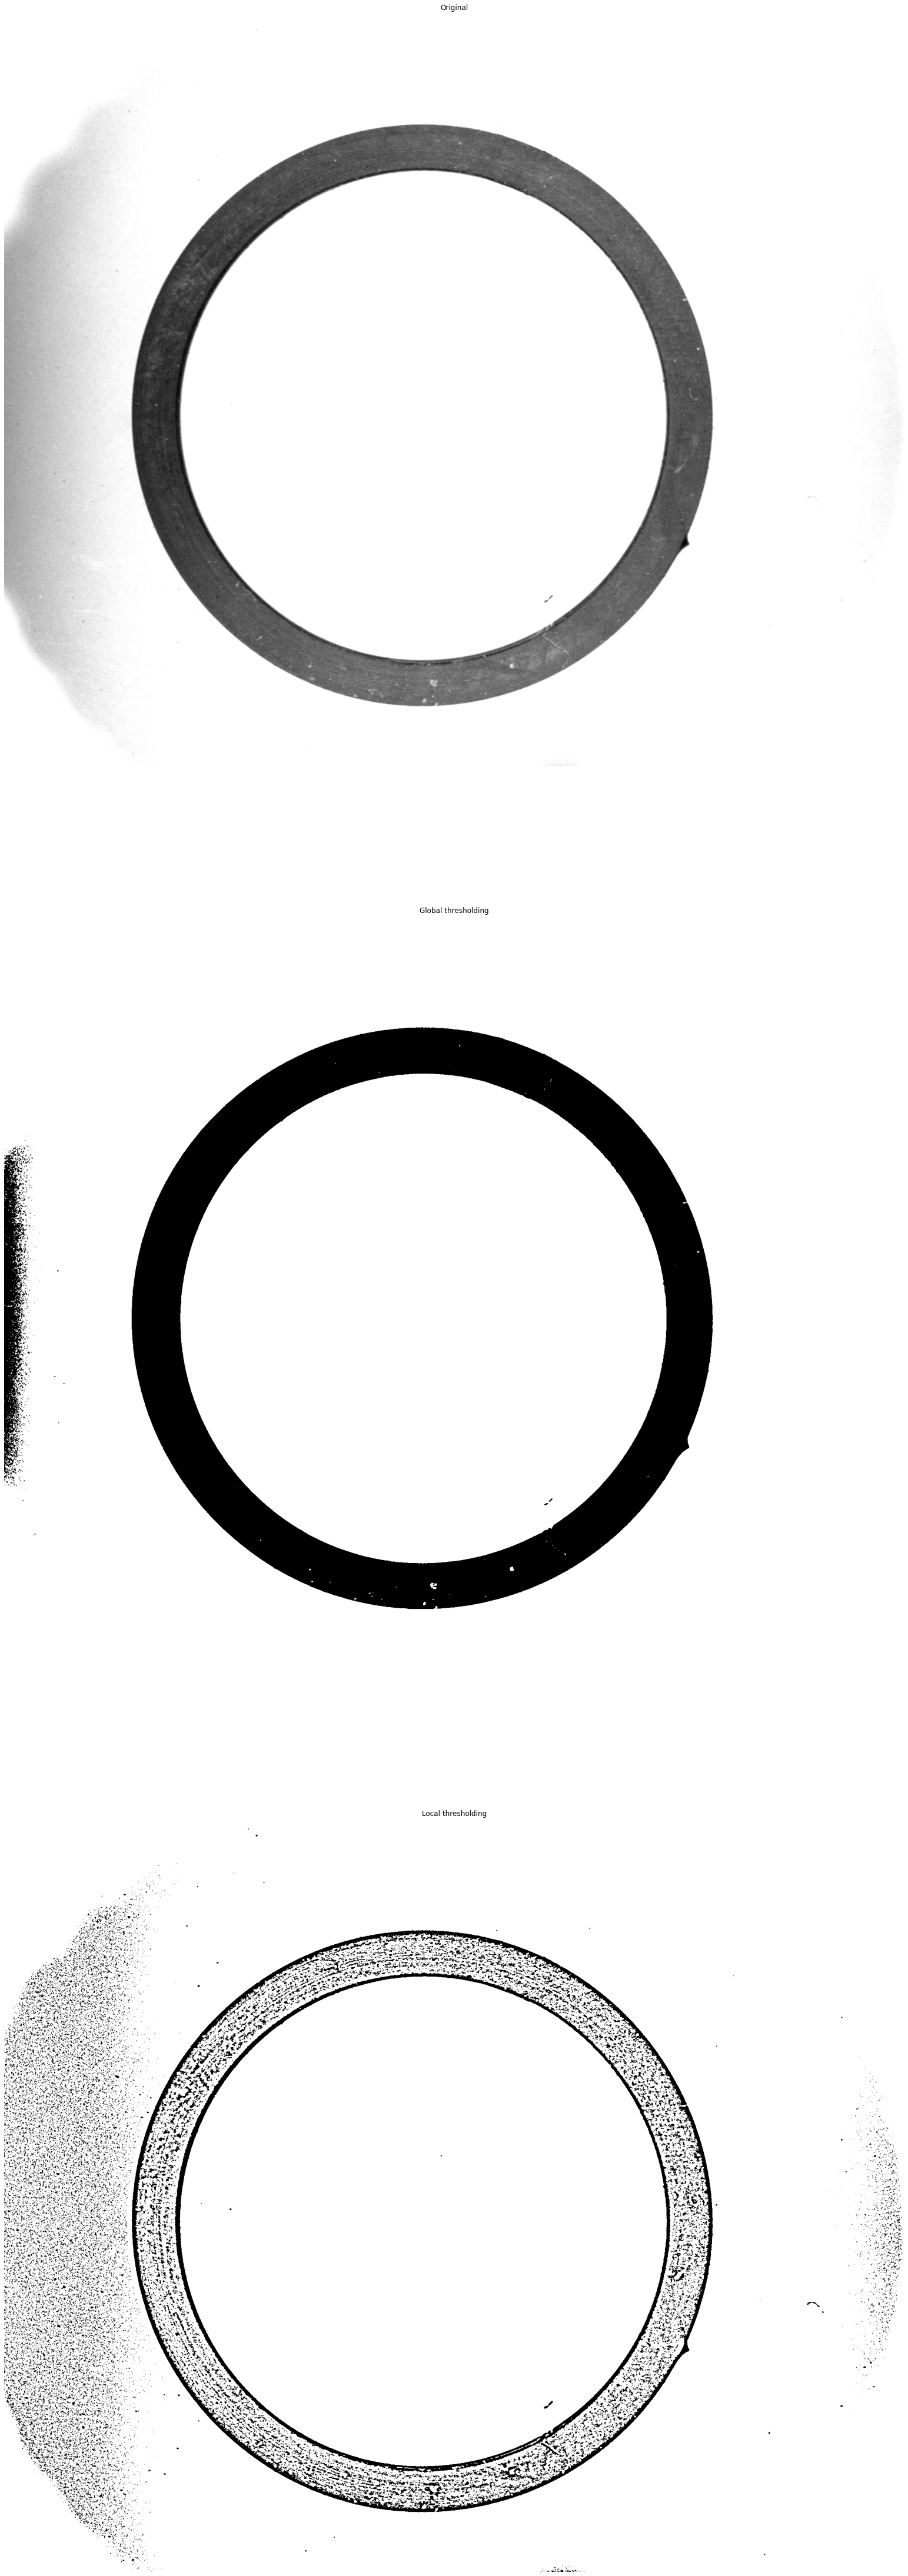

In [60]:
from skimage.filters import threshold_otsu, threshold_local


image = original_image
image = cv2.GaussianBlur(image,(3,3),0,0)

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 35
local_thresh = threshold_local(image, block_size, offset=3)
binary_local = image > local_thresh

fig, axes = plt.subplots(nrows=3, figsize=(70, 80))
ax = axes.ravel()
plt.gray()

ax[0].imshow(image)
ax[0].set_title('Original')

ax[1].imshow(binary_global)
ax[1].set_title('Global thresholding')

ax[2].imshow(binary_local)
ax[2].set_title('Local thresholding')

for a in ax:
    a.axis('off')

plt.show()

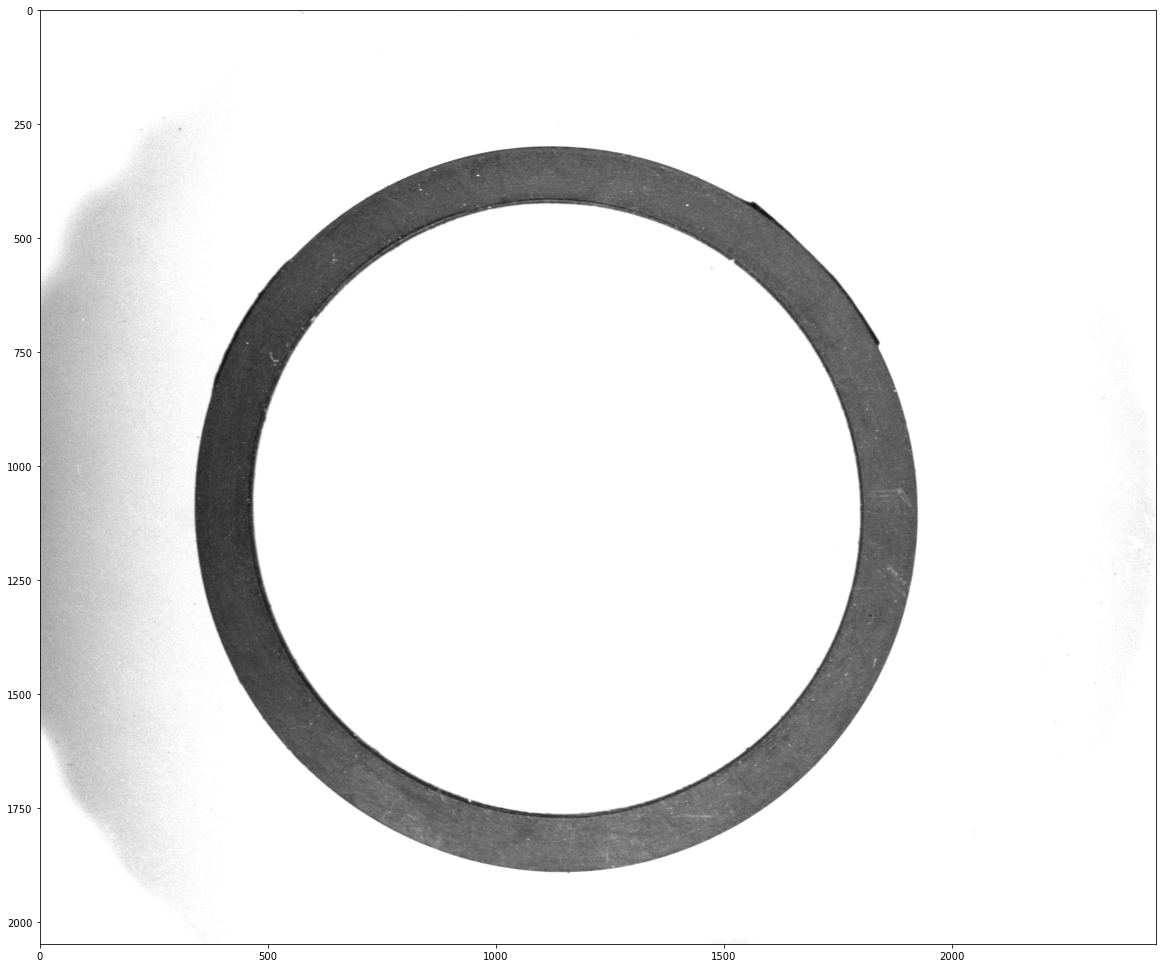

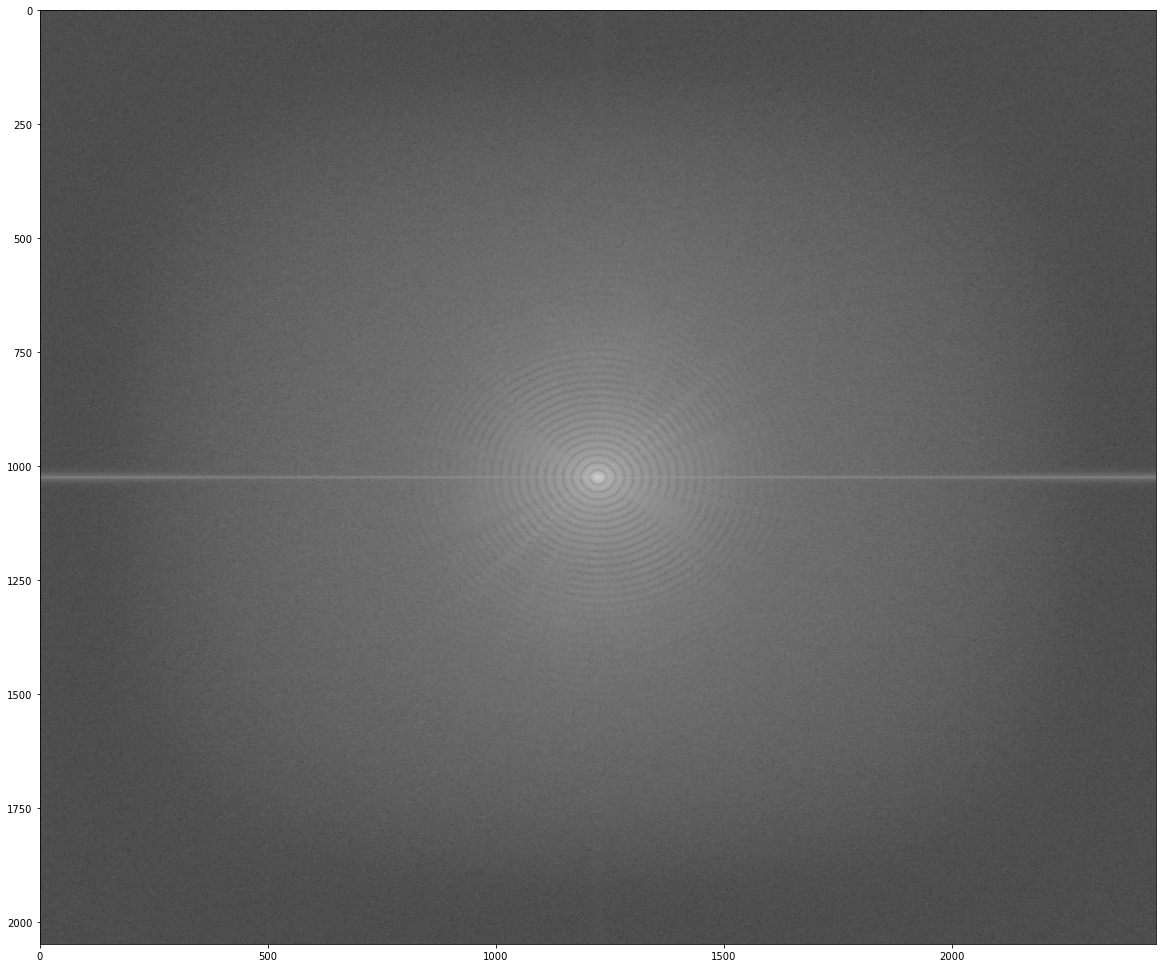

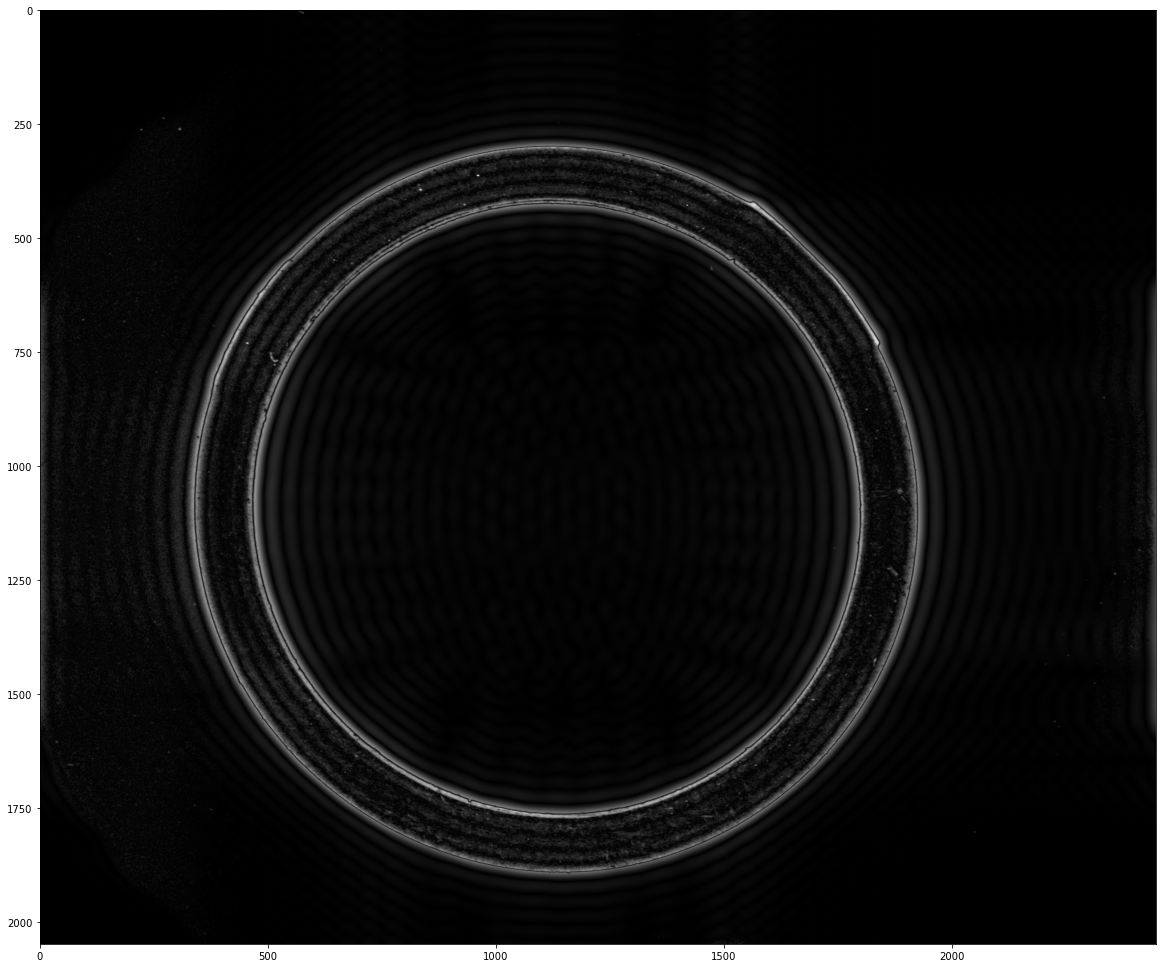

In [72]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

original_image = np.array(cv2.imread("0518ALL_Data/CCD-2/108.jpg",0))
plt.figure(figsize=(20,20))
plt.imshow(original_image,cmap = 'gray')

img = original_image
img = cv2.GaussianBlur(img,(3,3),0,0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
plt.figure(figsize=(20,20))
plt.imshow(magnitude_spectrum)


rows, cols = img.shape
crow,ccol = rows//2 , cols//2
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)
plt.figure(figsize=(20,20))
plt.imshow(img_back)